# TEAM GLT - Geoscience Hackathon 24
**Members:** Zulkuf Azizoglu, Cinar Turhan, Fehmi Ozbayrak

**Project Based On:** https://github.com/zsylvester/segmenteverygrain (Dr. Zoltán Sylvester)

## Project Overview

This project aims to provide the end user with a workflow that takes an image of a grain collection of any sorts, and calculate the statistical and possibly the geological quantitative properties of the grains



### 0- Before starting & Requirements
`conda` is essential for this project, though it could be done without it. This workflow will assume that the user has installed conda.
- Create a conda virtual environment
(On Linux&Mac, it is `conda env create -f myenv.conda`)
- Activate that conda virtual environment 
(On Linux&Mac, it is `conda activate myenv`)
- Install packages using `environment.yml`
(On Linux&Mac, it is `conda env update --file environment.yml --prune`, make sure that the running terminal is in the same working directory with `environment.yml`)
- Run `pip install segmenteverygrain`

### 1- Import libraries
We start by importing the necessary libraries for the project

In [1]:
import pandas as pd # for tabular data handling
import numpy as np # for calculations in general
import matplotlib.pyplot as plt # visualizing the results
import random # for random colors
import cv2 # image manipulation
import segmenteverygrain as seg # 'segmenteverygrain' 

from shapely.wkt import loads as load_wkt # for reading polygons from .csv
from skimage import measure # for image handling
from skimage.measure import regionprops, regionprops_table # for image handling
from tensorflow.keras.optimizers.legacy import Adam # Adam optimizer
from tensorflow.keras.preprocessing.image import load_img # image loader for keras
from importlib import reload
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor # necessary functions for segmentation
from tqdm import trange # for displaying iteration count

2024-10-06 03:51:29.571979: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 03:51:29.604364: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 03:51:29.605102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 03:51:30.243275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Default arguments for the model given in the original work
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])

# Fine-tuned weights
model.load_weights('./checkpoints/seg_model') 

# SAM (Segment Anything Model) checkpoint. Can be downloaded from: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")

2024-10-06 03:51:32.476100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-06 03:51:32.476604: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### 2- Segmentation

We mainly refer to the work in the original repository, and only write a wrapper around it to capture a tabular data, which is going to be sufficient for our work.

In [3]:
# Image segmenter: Segments each grain in a given image by assigning them unique labels.
def image_segmenter(fname, save=True):

        # Loading the image
        image = np.array(load_img(fname))

        # Predict the entire image. I is the size of square-shaped image tiles in pixels.
        image_pred = seg.predict_image(image, model, I=256)

        # Obtaining labels and coordinates for each grain
        # Decreasing the 'dbs_max_dist' parameter results in more SAM prompts (and longer processing times):
        labels, coords = seg.label_grains(image, image_pred, dbs_max_dist=20.0) # Unet prediction

        # SAM segmentation, using the point prompts from the Unet:
        all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, image, image_pred, 
                                                        coords, labels, min_area=400.0, plot_image=False, remove_edge_grains=True, remove_large_objects=False)


        # Scaling parameters for the conversion of length to the real value
        n_of_units = 1000 # ?
        units_per_pixel = n_of_units/1552.77 # length of scale bar in pixels

        # Storing the data as a dataframe
        props = regionprops_table(labels.astype('int'), intensity_image = image, properties =\
                ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length', 
                'orientation', 'perimeter', 'max_intensity', 'mean_intensity', 'min_intensity'))
        grain_data = pd.DataFrame(props)
        grain_data['major_axis_length'] = grain_data['major_axis_length'].values*units_per_pixel
        grain_data['minor_axis_length'] = grain_data['minor_axis_length'].values*units_per_pixel
        grain_data['perimeter'] = grain_data['perimeter'].values*units_per_pixel
        grain_data['area'] = grain_data['area'].values*units_per_pixel**2

        # Creating a new column 'polygons' in the grain_data DataFrame
        grain_data['polygons'] = all_grains

        # Saving the dataframe as .csv if toggled on
        if(save):
                # Saving the DataFrame to a CSV file
                csv_filename = fname.split('.')[0] + '_data.csv'
                grain_data.to_csv(csv_filename, index=False)
                print(f"DataFrame successfully saved to {csv_filename}")
        else:
                pass

        return grain_data

### 3- Import data & Visualize
This is where the user can input any rock image

<span style="color:red">The parameters for scaling the image to match the real world length must be also adjusted accordingly</span>

In [17]:
# Put the image in the same folder with this notebook
#grain_data = image_segmenter('cropped.jpg')

# For the moment, we use already generated dataset
grain_data = pd.read_csv('coconino.csv')
# Convert the 'polygons' column from WKT (well-known text) to Shapely Polygon objects
grain_data['polygons'] = grain_data['polygons'].apply(load_wkt)

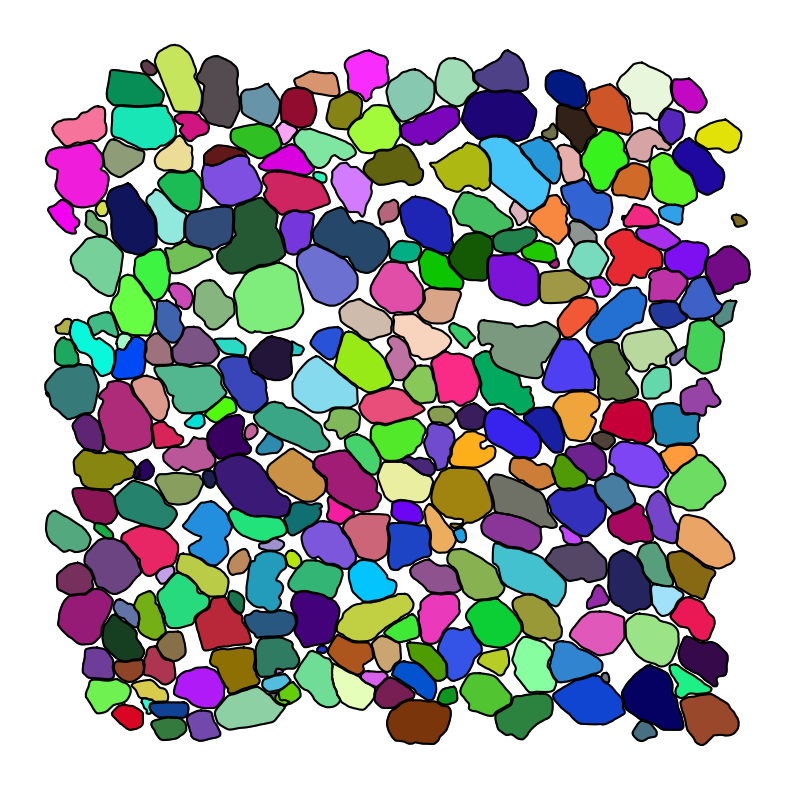

In [27]:
# Plot all polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Turn off the axes
ax.set_axis_off()

# Set a random seed for consistent color generation
random.seed(42)

# Generate a list of random colors for the polygons
colors = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(len(grain_data['polygons']))]

# Plot each polygon from the 'polygons' column with a different color
for polygon, color in zip(grain_data['polygons'], colors):
    x, y = polygon.exterior.xy
    ax.fill(x, y, color=color)  # Fill the polygon with color
    ax.plot(x, y, color='black')          # Optionally plot the boundary

plt.savefig('output_images/grains_colored.png', bbox_inches='tight')
plt.show()

### 4- Statistical & Geological Properties

#### a. Area Distribution

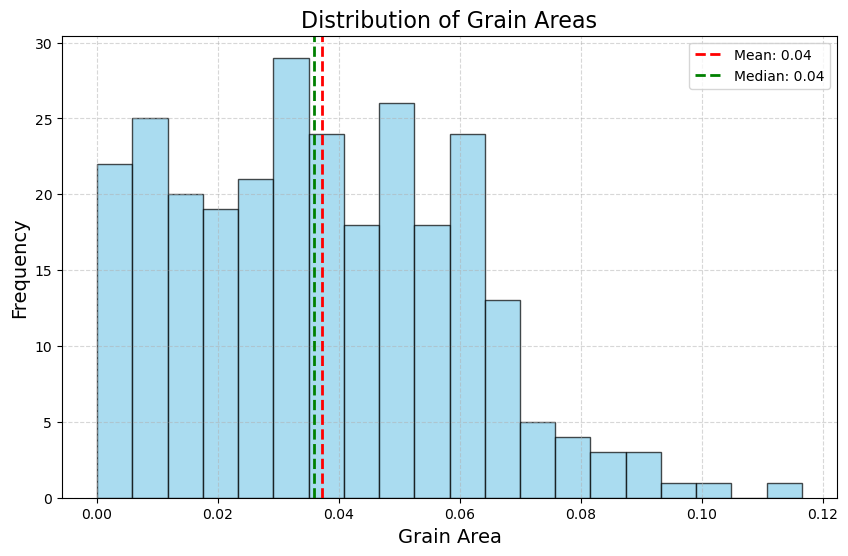

In [24]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram
n, bins, patches = ax.hist(grain_data['area'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title
ax.set_xlabel('Grain Area', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of Grain Areas', fontsize=16)

# Add grid
ax.grid(True, linestyle='--', alpha=0.5)

# Add mean and median lines
mean_area = np.mean(grain_data['area'])
median_area = np.median(grain_data['area'])
ax.axvline(mean_area, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_area:.2f}')
ax.axvline(median_area, color='green', linestyle='--', linewidth=2, label=f'Median: {median_area:.2f}')

# Add a legend
ax.legend()

# Show the plot
plt.savefig('output_images/area_histogram')
plt.show()

#### b. Sphericity Distribution

- There are many ways of calculating the sphericity. This workflow will use 2 simple ways that can be obtained from the existing data directly.

##### i - Area Sphericity
$S_{A}=\frac{A_{S}}{A_{cir}}$, where $A_{S}$ is the obtained surface area of the grain and $A_{cir}$ is the area of the circle with $r=L_{major}$

##### ii - Width to Length Ratio Sphericity
$S_{WL}=\frac{L_{minor}}{L_{major}}$, where $L_{minor}$ and $L_{major}$ are minor and major axis lengths, respectively.

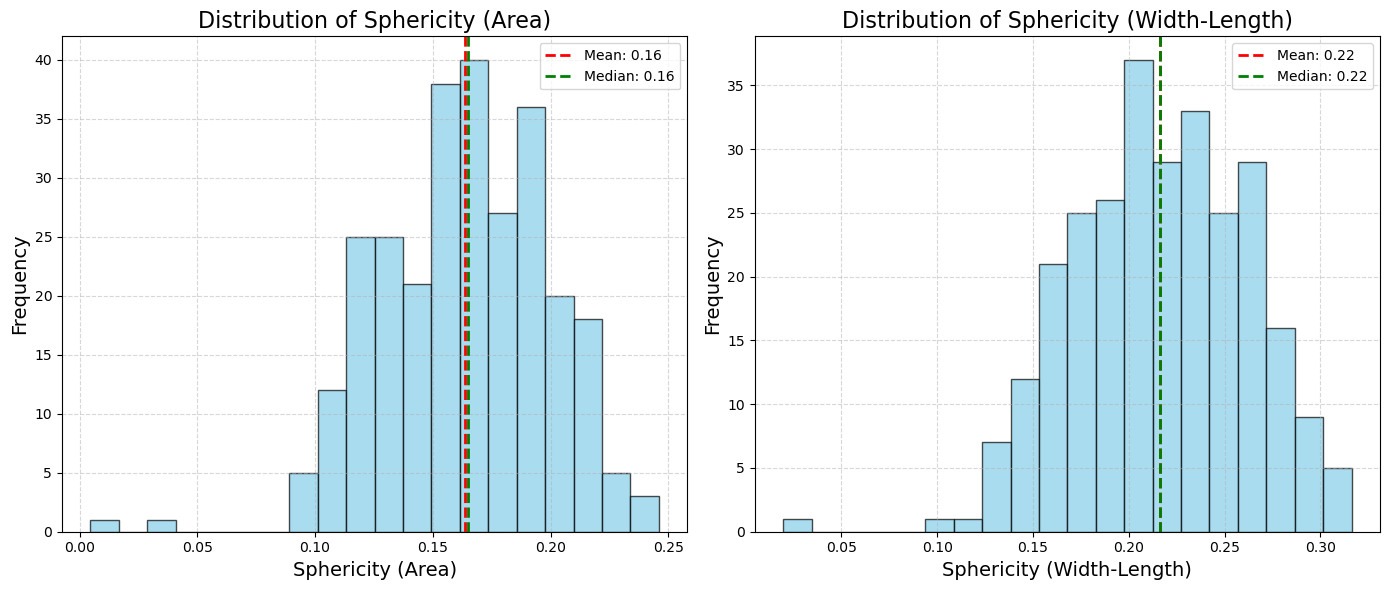

In [25]:
# Calculating the sphericities
grain_data['sphericity_a'] = grain_data['area']/ (np.pi * grain_data['major_axis_length']**2)
grain_data['sphericity_wl'] = grain_data['minor_axis_length']/ (np.pi * grain_data['major_axis_length'])

# Plotting the results
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for sphericity_a
n_a, bins_a, patches_a = ax1.hist(grain_data['sphericity_a'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Sphericity (Area)', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.set_title('Distribution of Sphericity (Area)', fontsize=16)

# Calculate mean and median for sphericity_a
mean_a = np.mean(grain_data['sphericity_a'])
median_a = np.median(grain_data['sphericity_a'])

# Add mean and median lines
ax1.axvline(mean_a, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_a:.2f}')
ax1.axvline(median_a, color='green', linestyle='--', linewidth=2, label=f'Median: {median_a:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# Histogram for sphericity_wl
n_wl, bins_wl, patches_wl = ax2.hist(grain_data['sphericity_wl'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Sphericity (Width-Length)', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.set_title('Distribution of Sphericity (Width-Length)', fontsize=16)

# Calculate mean and median for sphericity_wl
mean_wl = np.mean(grain_data['sphericity_wl'])
median_wl = np.median(grain_data['sphericity_wl'])

# Add mean and median lines
ax2.axvline(mean_wl, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_wl:.2f}')
ax2.axvline(median_wl, color='green', linestyle='--', linewidth=2, label=f'Median: {median_wl:.2f}')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('output_images/sphericity_histogram')
plt.show()

##### iii - Wadell Sphericity
Wadell Sphericity is calculated as

$S_{W}=1.141C^{2}-0.8073C+0.633$ where C, circularity, is calculated as $C=({\frac{P^{2}}{4\pi A}})^{-1}$. $P$ is perimeter and $A$ is area, both of which are given by the segmentation workflow.

In [29]:
# Function to calculate Wadell Sphericity
def wadell_sphericity(perimeter, area): # also called shape factor    
    circularity = 1/(perimeter**2 / (4 * np.pi * area))
    sphericity = 1.141 * circularity ** 2 - 0.8073 * circularity + 0.633
    return circularity, sphericity 

# Apply the function to each row
grain_data[['circularity', 'sphericity_w']] = grain_data.apply(
    lambda row: wadell_sphericity(row['perimeter'], row['area']), axis=1, result_type='expand'
)

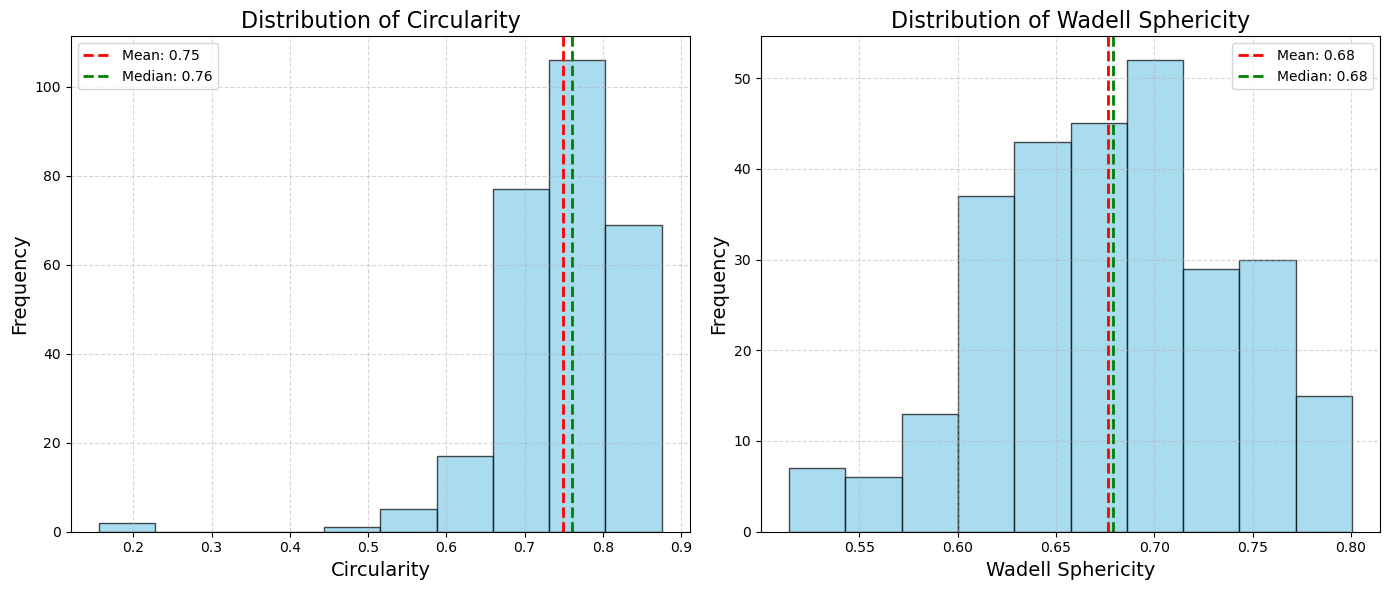

In [30]:
# Plotting results
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for circularity
n_circularity, bins_circularity, patches_circularity = ax1.hist(grain_data['circularity'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Circularity', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.set_title('Distribution of Circularity', fontsize=16)

# Calculate mean and median for circularity
mean_circularity = np.mean(grain_data['circularity'])
median_circularity = np.median(grain_data['circularity'])

# Add mean and median lines
ax1.axvline(mean_circularity, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_circularity:.2f}')
ax1.axvline(median_circularity, color='green', linestyle='--', linewidth=2, label=f'Median: {median_circularity:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# Histogram for sphericity_w
n_sphericity, bins_sphericity, patches_sphericity = ax2.hist(grain_data['sphericity_w'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Wadell Sphericity', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.set_title('Distribution of Wadell Sphericity', fontsize=16)

# Calculate mean and median for sphericity_w
mean_sphericity = np.mean(grain_data['sphericity_w'])
median_sphericity = np.median(grain_data['sphericity_w'])

# Add mean and median lines
ax2.axvline(mean_sphericity, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sphericity:.2f}')
ax2.axvline(median_sphericity, color='green', linestyle='--', linewidth=2, label=f'Median: {median_sphericity:.2f}')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('output_images/wadell_sphericity_histogram')
plt.show()

#### c. Sortedness

### Zulkuf to fill

Phi Percentile Values:
φ5: 1.69
φ16: 1.85
φ25: 1.94
φ50: 2.23
φ75: 2.71
φ84: 3.07
φ95: 3.72

Calculated Parameters:
Mean Grain Size (Mφ): 2.38
Sorting Coefficient (σφ): 0.61
Skewness (Skφ): 0.43


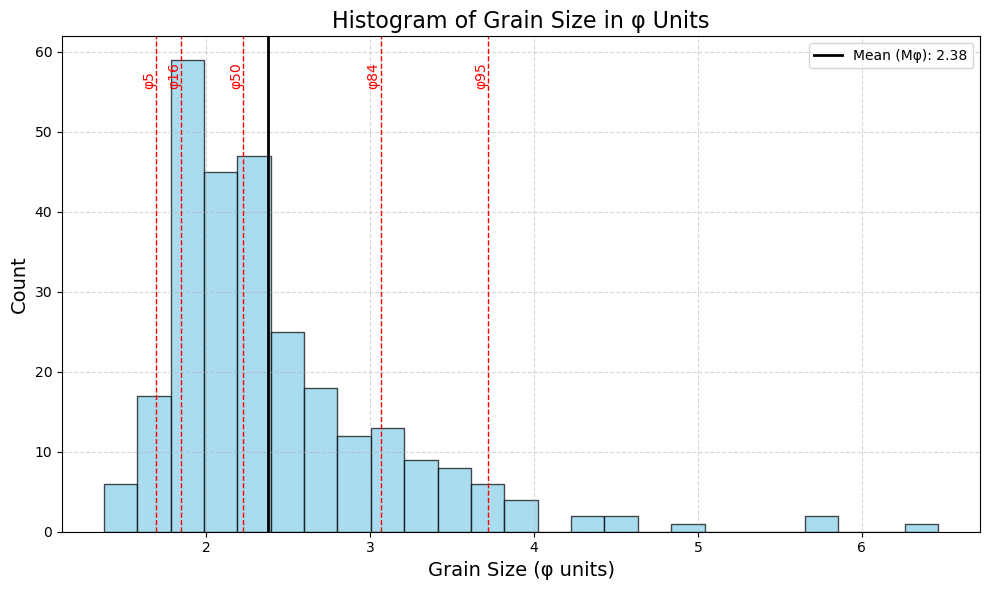

In [31]:
# Calculate average grain radius by area
grain_data['radius'] = np.sqrt(grain_data['area'] / np.pi)

# Convert diameters to phi units
grain_data['phi'] = -np.log2(2 * grain_data['radius'])

# Define the percentiles to calculate
percentiles = [5, 16, 25, 50, 75, 84, 95]

# Calculate phi percentiles
phi_percentiles = np.percentile(grain_data['phi'], percentiles)

# Create a dictionary to map percentile labels to values
phi_perc_dict = dict(zip(percentiles, phi_percentiles))

# Calculate mean grain size in phi units
M_phi = (phi_perc_dict[16] + phi_perc_dict[50] + phi_perc_dict[84]) / 3

# Calculate sorting coefficient
sigma_phi = ((phi_perc_dict[84] - phi_perc_dict[16]) / 4) + ((phi_perc_dict[95] - phi_perc_dict[5]) / 6.6)

# Calculate skewness
Sk_phi = ((phi_perc_dict[16] + phi_perc_dict[84] - 2 * phi_perc_dict[50]) / (2 * (phi_perc_dict[84] - phi_perc_dict[16]))) + \
         ((phi_perc_dict[5] + phi_perc_dict[95] - 2 * phi_perc_dict[50]) / (2 * (phi_perc_dict[95] - phi_perc_dict[5])))

# Print the percentile values
print("Phi Percentile Values:")
for perc in percentiles:
    print(f"φ{perc}: {phi_perc_dict[perc]:.2f}")

# Print the calculated parameters
print("\nCalculated Parameters:")
print(f"Mean Grain Size (Mφ): {M_phi:.2f}")
print(f"Sorting Coefficient (σφ): {sigma_phi:.2f}")
print(f"Skewness (Skφ): {Sk_phi:.2f}")

# Plot histogram of phi values
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(grain_data['phi'], bins=25, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Grain Size (φ units)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Histogram of Grain Size in φ Units', fontsize=16)

# Plot vertical lines for percentiles
for perc in [5, 16, 50, 84, 95]:
    plt.axvline(phi_perc_dict[perc], color='red', linestyle='--', linewidth=1)
    plt.text(phi_perc_dict[perc], plt.ylim()[1]*0.9, f'φ{perc}', rotation=90, color='red', ha='right')

# Plot vertical line for mean grain size
plt.axvline(M_phi, color='black', linestyle='-', linewidth=2, label=f'Mean (Mφ): {M_phi:.2f}')
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('output_images/sortedness')
plt.show()

#### d. Roundness

This part will be implemented in future